# Settings

In [ ]:
%%capture
!pip install uproot

In [28]:
import os

# Define your workspace directory
workspace_dir = '/content/anomaly-detection-in-HEP/code'

# Create the directory if it doesn't exist
if not os.path.exists(workspace_dir):
    os.makedirs(workspace_dir)

# Change the current working directory to your workspace directory
os.chdir(workspace_dir)

# Verify the current working directory
print('Current working directory:', os.getcwd())


Current working directory: /content/anomaly-detection-in-HEP/code


In [29]:
from torch.utils.data import DataLoader
from google.cloud import storage
from io import BytesIO
import uproot
from itertools import chain
import numpy as np
import torch
import h5py
from array import array
import os
import torch.optim as optim
from sklearn.metrics import accuracy_score
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from matplotlib import pyplot as plt

## Data loading

In [30]:
def get_data_from_h5(file_dir:str = 'QCD_LLP_samples/preprocessed_data.h5',
                     bucket_name:str = 'cuda-programming-406720'):
  client = storage.Client()
  bucket = client.get_bucket(bucket_name)
  blob = bucket.blob(file_dir)
  file_contents = BytesIO(blob.download_as_string())
  with h5py.File(file_contents, 'r') as f:
    dataset_train = f['train']
    dataset_valid = f['valid']
    dataset_test = f['test']
    d1 = dataset_train[:]
    d2 = dataset_valid[:]
    d3 = dataset_test[:]
  return d1, d2, d3

data_train, data_valid, data_test = get_data_from_h5()

In [31]:
mins = data_train[:,:5].min(axis=0)
maxs = data_train[:,:5].max(axis=0)
labels_train = data_train[:, -1]
labels_test = data_test[:, -1]
labels_valid = data_valid[:, -1]

In [32]:
data_train = (data_train[:,:5] - mins)/(maxs - mins)
data_test = (data_test[:,:5] - mins)/(maxs - mins)
data_valid = (data_valid[:,:5] - mins)/(maxs - mins)

In [33]:
data_bkg_train = torch.tensor(data_train[labels_train==0, :5][:5_000_000,:])
data_sig_train = torch.tensor(data_train[labels_train==1, :5][:5_000_000,:])

In [34]:
data_bkg_valid = torch.tensor(data_valid[labels_valid==0, :5][:500_000,:])
data_sig_valid = torch.tensor(data_valid[labels_valid==1, :5][:500_000,:])

In [35]:
data_bkg_test = torch.tensor(data_test[labels_test==0, :5][:500_000,:])
data_sig_test = torch.tensor(data_test[labels_test==1, :5][:500_000,:])

In [36]:
del data_train

# Train VAE model

In [40]:
BATCH_SIZE = 10_000
DROPOUT_RATE = 0.01
beta = 0.1
lr = 1e-1
latent_dim = 2
num_epochs = 100

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(in_features=input_dim, out_features=64)
        self.fc21 = nn.Linear(in_features=64, out_features=latent_dim)
        self.fc22 = nn.Linear(in_features=64, out_features=latent_dim)
        self.fc3 = nn.Linear(in_features=latent_dim, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=input_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(DROPOUT_RATE)

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        # if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return mu + eps*std
        # else:
            # return mu

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        recon_loss = torch.mean(torch.pow(recon_x - x, 2)) #/ BATCH_SIZE
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) #/ BATCH_SIZE
        return (1-beta)*recon_loss + beta*kl_loss


class AE(nn.Module):
    def __init__(self, input_dim, latent_dim, dropout_rate=0.1):
        super(AE, self).__init__()

        self.fc1 = nn.Linear(in_features=input_dim, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=latent_dim)
        self.fc3 = nn.Linear(in_features=latent_dim, out_features=512)
        self.fc4 = nn.Linear(in_features=512, out_features=input_dim)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc2(h1)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.tanh(self.fc4(h3))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def loss_function(self, recon_x, x):
        recon_loss = torch.mean(torch.pow(recon_x - x, 2))  # Mean Squared Error Loss
        return recon_loss

In [41]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vae = VAE(input_dim=5, latent_dim=latent_dim)
model_vae = model_vae.to(device)
summary(model_vae, input_size=(5,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             384
              ReLU-2                   [-1, 64]               0
            Linear-3                    [-1, 2]             130
            Linear-4                    [-1, 2]             130
            Linear-5                   [-1, 64]             192
              ReLU-6                   [-1, 64]               0
            Linear-7                    [-1, 5]             325
           Sigmoid-8                    [-1, 5]               0
Total params: 1,161
Trainable params: 1,161
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [42]:
from datetime import datetime

train_loader = DataLoader(data_bkg_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)
valid_loader = DataLoader(data_bkg_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=10)
optimizer=optim.Adam(model_vae.parameters(), lr=0.001)

train_losses = []
valid_losses = []
for epoch in range(num_epochs):
  starting_time = datetime.now()
  epoch_train_loss = 0.0
  epoch_valid_loss = 0.0

  # Training
  model_vae.train()
  for inputs in train_loader:
    optimizer.zero_grad()
    inputs = inputs.to(device)
    # inputs_recon = model_vae(inputs)
    # inputs_recon = inputs_recon.to(device)
    # train_loss = model_vae.loss_function(inputs, inputs_recon)
    inputs_recon, mu, logvar = model_vae(inputs)
    inputs_recon, mu, logvar = inputs_recon.to(device), mu.to(device), logvar.to(device)
    train_loss = model_vae.loss_function(inputs, inputs_recon, mu, logvar)
    train_loss.backward()
    optimizer.step()
    epoch_train_loss += train_loss.item()

  # Validation
  model_vae.eval()
  with torch.no_grad():
    for data in valid_loader:
          x = data
          inputs = x.to(device)
          # inputs_recon = model_vae(inputs)
          # inputs_recon = inputs_recon.to(device)
          # valid_loss = model_vae.loss_function(inputs, inputs_recon)
          x_recon, mu, logvar = model_vae(inputs)
          x_recon, mu, logvar = x_recon.to(device), mu.to(device), logvar.to(device)
          valid_loss = model_vae.loss_function(inputs, x_recon, mu, logvar)
          epoch_valid_loss += valid_loss.item()

  epoch_train_loss /= len(train_loader)
  epoch_valid_loss /= len(valid_loader)

  train_losses.append(epoch_train_loss)
  valid_losses.append(epoch_valid_loss)

  time_elapsed = datetime.now() - starting_time
  print('Epoch: {}, Train len batch: {}, Train loss: {:.10f}, Valid loss: {:.10f}, Time elapsed (hh:mm:ss.ms) {}'.format(
                    epoch,len(train_loader) ,epoch_train_loss, epoch_valid_loss, time_elapsed
  ))


Epoch: 0, Train len batch: 500, Train loss: 0.0205027343, Valid loss: 0.0161837158, Time elapsed (hh:mm:ss.ms) 0:00:07.425477
Epoch: 1, Train len batch: 500, Train loss: 0.0161035804, Valid loss: 0.0159978806, Time elapsed (hh:mm:ss.ms) 0:00:06.710530
Epoch: 2, Train len batch: 500, Train loss: 0.0160220164, Valid loss: 0.0159687355, Time elapsed (hh:mm:ss.ms) 0:00:07.514350
Epoch: 3, Train len batch: 500, Train loss: 0.0160050367, Valid loss: 0.0159562957, Time elapsed (hh:mm:ss.ms) 0:00:06.935910
Epoch: 4, Train len batch: 500, Train loss: 0.0159997588, Valid loss: 0.0159538414, Time elapsed (hh:mm:ss.ms) 0:00:06.699774
Epoch: 5, Train len batch: 500, Train loss: 0.0159970006, Valid loss: 0.0159559433, Time elapsed (hh:mm:ss.ms) 0:00:07.111979
Epoch: 6, Train len batch: 500, Train loss: 0.0159965558, Valid loss: 0.0159526794, Time elapsed (hh:mm:ss.ms) 0:00:07.234656
Epoch: 7, Train len batch: 500, Train loss: 0.0159960213, Valid loss: 0.0159539267, Time elapsed (hh:mm:ss.ms) 0:00:06

In [ ]:
import seaborn as sns
sns.lineplot(train_losses)
# plt.ylim((0,20))

(0.0159, 0.017)

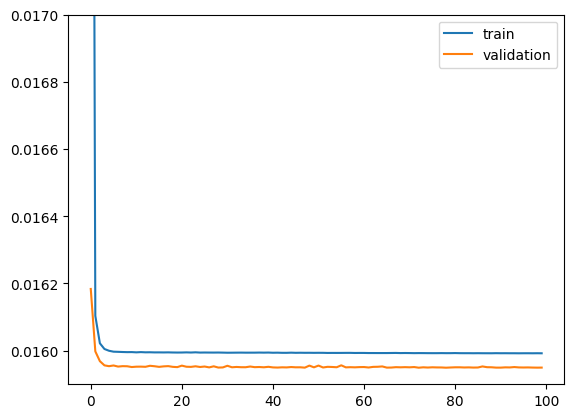

In [58]:
plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="validation")
plt.legend()
plt.ylim((0.0159, 0.017))

# Test the model

In [50]:
bkg_mse = []
for x in data_bkg_test[:500,:]:
  x = x.to(device)
  x_recon, mu, logvar = model_vae(x)
  mse = model_vae.loss_function(x, x_recon, mu, logvar)
  if mse.item()<0:
    print(mse)
  bkg_mse.append(mse.item())

In [51]:
sig_mse = []
for x in data_sig_train[:500,:]:
  x = x.to(device)
  x_recon, mu, logvar = model_vae(x)
  mse = model_vae.loss_function(x, x_recon, mu, logvar)
  if mse.item()<0:
    print(mse)
  sig_mse.append(mse.item())

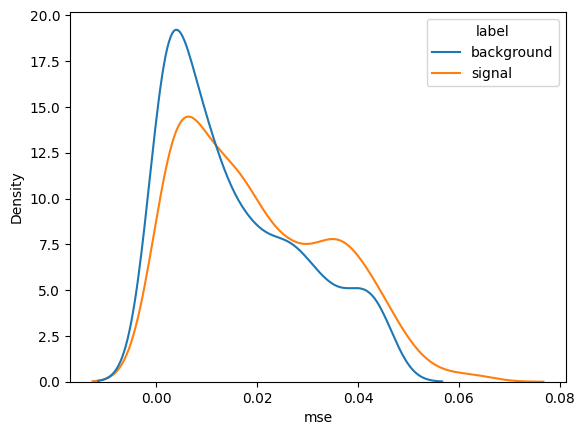

In [52]:
import seaborn as sns
import pandas as pd

hist_data = pd.DataFrame({'mse': bkg_mse+sig_mse, 'label': ['background']*len(bkg_mse) + ['signal']*len(sig_mse)})
sns.kdeplot(data=hist_data, x='mse', hue='label')
# plt.xlim((0,3))
plt.show()

In [ ]:
len(sig_mse)

5840319